In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

In [3]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [4]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

In [5]:
# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

In [6]:
X.shape

(8147, 16)

In [7]:
X.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0


In [8]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [9]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

In [10]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [11]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [12]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

In [13]:
table_train

col_0,0.0,1.0,All
partner,,,
0.0,4167,341,4508
1.0,1291,1533,2824
All,5458,1874,7332


In [14]:
print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


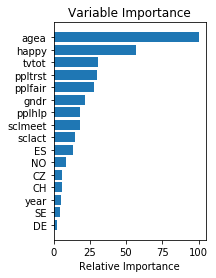

In [15]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis of boosting for this particular problem
Degrees of freedom:
    1. loss function
    2. subsampling
    3. n_estimators (# iterations)
    4. tree depth 
        
I am purposely ignoring the learning_rate parameter because it is related to n_estimators. 

Questions:
a. How do the deviance and the accuracy depend on the parameters. 
b. What is the relationship between between accuracy and deviance. 

In [16]:
lossFcts = ['deviance','exponential']
subsamplingVec = np.arange(0.5,1.25,0.25)
depthVec = [2, 3, 4]
n_est = 500

In [17]:
train_deviance = np.zeros((len(lossFcts), len(depthVec), len(subsamplingVec), n_est), dtype=np.float64)
test_deviance =  np.zeros((len(lossFcts), len(depthVec), len(subsamplingVec), n_est), dtype=np.float64)
train_accuracy = np.zeros((len(lossFcts), len(depthVec), len(subsamplingVec), n_est), dtype=np.float64)
test_accuracy = np.zeros((len(lossFcts), len(depthVec), len(subsamplingVec), n_est), dtype=np.float64)

In [18]:
for i1 in range(0, len(lossFcts)): 
    auxLoss = lossFcts[i1]
    for i2 in range(0,len(depthVec)): 
        auxDepth = depthVec[i2]
        for i3 in range(0, len(subsamplingVec) ):  
            auxSubsample = subsamplingVec[i3]
            
            params = {'n_estimators': n_est,
                      'max_depth': auxDepth,
                      'loss': auxLoss,
                      'subsample': auxSubsample}


            clf = ensemble.GradientBoostingClassifier(**params)
            clf.fit(X_train, y_train)
                
            for i4, y_pred in enumerate(clf.staged_predict(X_train)):
                train_deviance[i1, i2, i3, i4] = clf.loss_(y_train, y_pred)
                
                table_train = pd.crosstab(y_train, pd.Categorical(pd.Series(y_pred, name='s'),categories=[0., 1.]), margins=True, dropna=False)
                train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
                train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']
                train_accuracy[i1, i2, i3, i4] = 1-train_tI_errors - train_tII_errors
            
            for i4, y_pred in enumerate(clf.staged_predict(X_test)):
                test_deviance[i1, i2, i3, i4] = clf.loss_(y_test, y_pred)
                
                table_test = pd.crosstab(y_test, pd.Categorical(pd.Series(y_pred, name='s'),categories=[0., 1.]), margins=True, dropna=False)
                test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
                test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
                test_accuracy[i1, i2, i3, i4] = 1-test_tI_errors - test_tII_errors
        



# Let's look at accuracy

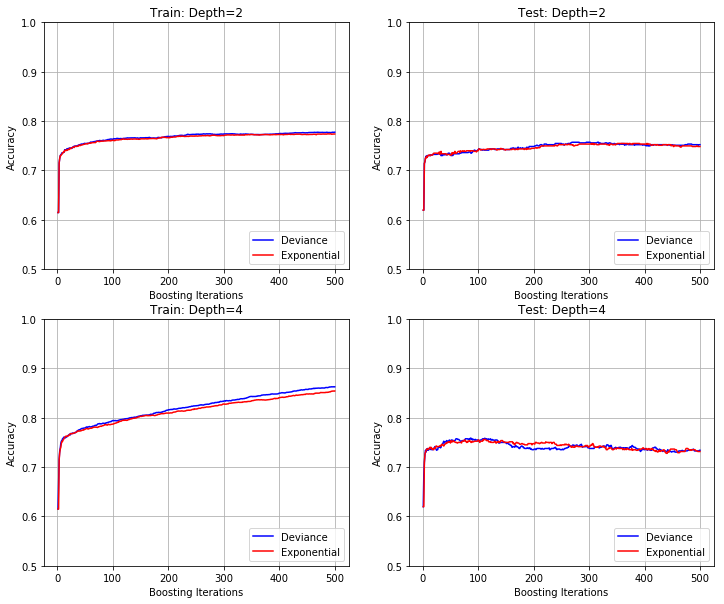

In [19]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title('Train: Depth='+str(depthVec[0]))
plt.plot(np.arange(n_est) + 1, train_accuracy[0,0,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, train_accuracy[1,0,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')

plt.subplot(2, 2, 2)
plt.title('Test: Depth='+str(depthVec[0]))
plt.plot(np.arange(n_est) + 1, test_accuracy[0,0,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, test_accuracy[1,0,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')

plt.subplot(2, 2, 3)
plt.title('Train: Depth='+str(depthVec[2]))
plt.plot(np.arange(n_est) + 1, train_accuracy[0,2,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, train_accuracy[1,2,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')


plt.subplot(2, 2, 4)
plt.title('Test: Depth='+str(depthVec[2]))
plt.plot(np.arange(n_est) + 1, test_accuracy[0,2,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, test_accuracy[1,2,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')

Observations:
    1. Exponential and Deviance loss functions appear to behave very similarly. We will henceforth focus on deviance for simplicity.
    2. Deeper trees help in-sample by they don't help out-of-sample.

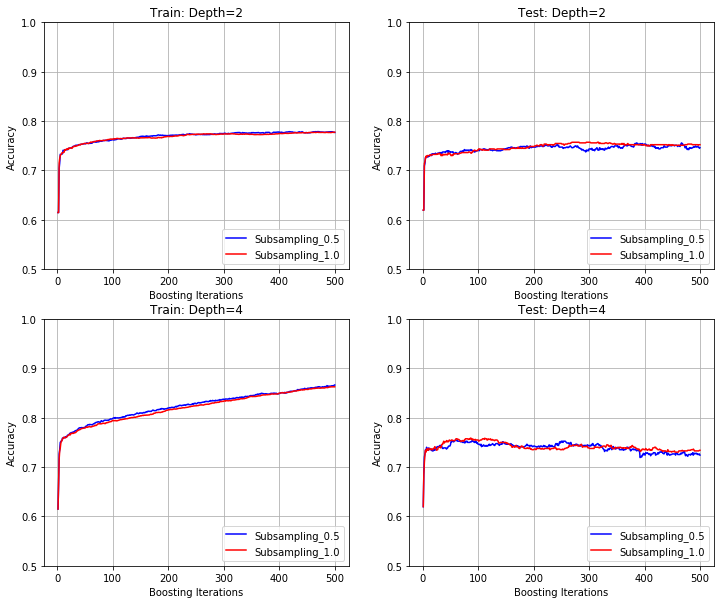

In [20]:
# train/test accuracy when comparing accuracy for different subsampling
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title('Train: Depth=2')
plt.plot(np.arange(n_est) + 1, train_accuracy[0,0,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, train_accuracy[0,0,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')

plt.subplot(2, 2, 2)
plt.title('Test: Depth=2')
plt.plot(np.arange(n_est) + 1, test_accuracy[0,0,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, test_accuracy[0,0,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')

plt.subplot(2, 2, 3)
plt.title('Train: Depth=4')
plt.plot(np.arange(n_est) + 1, train_accuracy[0,2,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, train_accuracy[0,2,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')

plt.subplot(2, 2, 4)
plt.title('Test: Depth=4')
plt.plot(np.arange(n_est) + 1, test_accuracy[0,2,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, test_accuracy[0,2,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid(b='on')



Subsampling doesn't seem to help! It even hurts a bit out of sample for larger depth of tree. 

From an accuracy perspective:
1. do subsampling = 1
2. use tree depth = 2
3. use deviance

We get an accuracy of about 75% out of sample, which was comparable to original. Changing these knobs has not gotten us much. 

# Let's look at loss

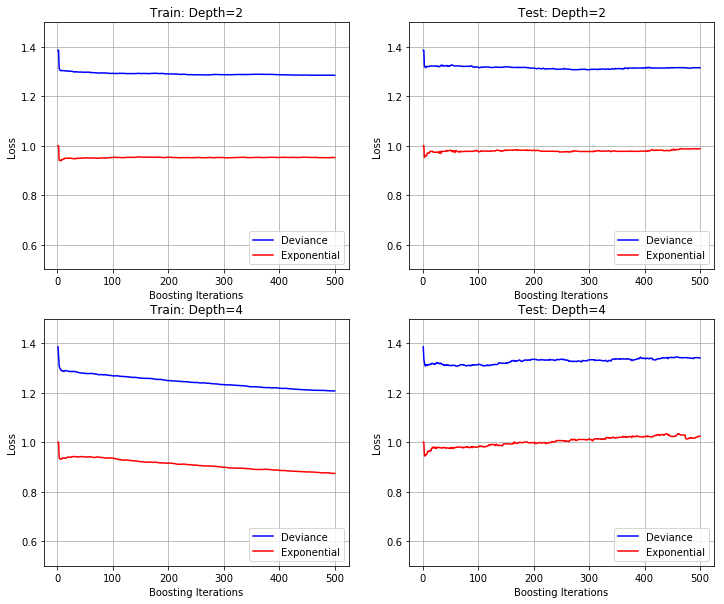

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title('Train: Depth='+str(depthVec[0]))
plt.plot(np.arange(n_est) + 1, train_deviance[0,0,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, train_deviance[1,0,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

plt.subplot(2, 2, 2)
plt.title('Test: Depth='+str(depthVec[0]))
plt.plot(np.arange(n_est) + 1, test_deviance[0,0,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, test_deviance[1,0,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

plt.subplot(2, 2, 3)
plt.title('Train: Depth='+str(depthVec[2]))
plt.plot(np.arange(n_est) + 1, train_deviance[0,2,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, train_deviance[1,2,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')


plt.subplot(2, 2, 4)
plt.title('Test: Depth='+str(depthVec[2]))
plt.plot(np.arange(n_est) + 1, test_deviance[0,2,2,:], 'b-',
         label='Deviance')
plt.plot(np.arange(n_est) + 1, test_deviance[1,2,2,:], 'r-',
         label='Exponential')
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

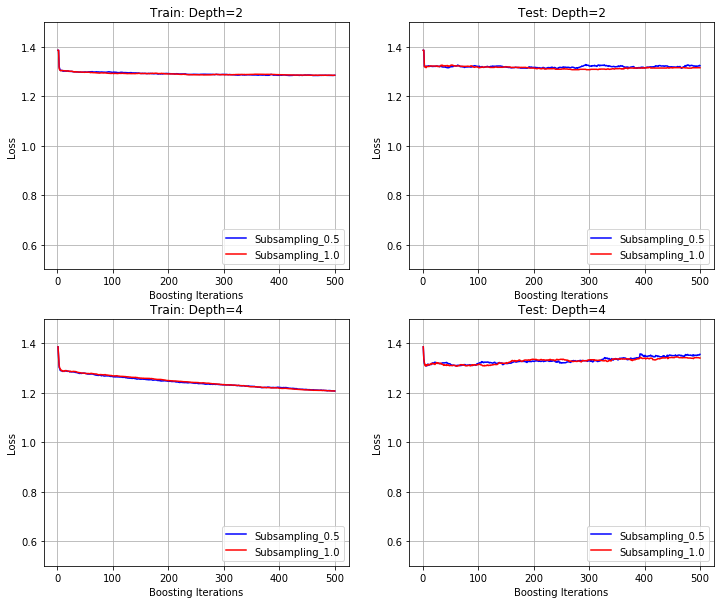

In [22]:
# train/test accuracy when comparing accuracy for different subsampling
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title('Train: Depth=2')
plt.plot(np.arange(n_est) + 1, train_deviance[0,0,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, train_deviance[0,0,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

plt.subplot(2, 2, 2)
plt.title('Test: Depth=2')
plt.plot(np.arange(n_est) + 1, test_deviance[0,0,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, test_deviance[0,0,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

plt.subplot(2, 2, 3)
plt.title('Train: Depth=4')
plt.plot(np.arange(n_est) + 1, train_deviance[0,2,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, train_deviance[0,2,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

plt.subplot(2, 2, 4)
plt.title('Test: Depth=4')
plt.plot(np.arange(n_est) + 1, test_deviance[0,2,0,:], 'b-',
         label='Subsampling_'+str(subsamplingVec[0]))
plt.plot(np.arange(n_est) + 1, test_deviance[0,2,2,:], 'r-',
         label='Subsampling_'+str(subsamplingVec[2]))
plt.legend(loc='lower right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.grid(b='on')

Why is the loss not decreasing, especially in the exponential case (not decreasing exponentially)? 

what is the difference between:
1. clf.staged_decision_function
2. clf.staged_predict?